In [37]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from multiprocessing import Pool
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [1]:
!cp -r /content/drive/MyDrive/cats-vs-dogs/PetImages /content/PetImages

In [8]:
base_path = '/content/PetImages'
cat_path = os.path.join(base_path, 'Cat')
dog_path = os.path.join(base_path, 'Dog')

cat_files = [os.path.join(cat_path, f) for f in os.listdir(cat_path) if f.endswith(('.jpg', '.png'))]
dog_files = [os.path.join(dog_path, f) for f in os.listdir(dog_path) if f.endswith(('.jpg', '.png'))]

df = pd.DataFrame({
    'filename': cat_files + dog_files,
    'label': [0]*len(cat_files) + [1]*len(dog_files)
})

def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        with Image.open(path) as img:
            img.load()
        return True
    except:
        return False

paths = df['filename'].tolist()

with Pool(processes=4) as pool:
    results = pool.map(is_valid_image, paths)

df = df[results].reset_index(drop=True)

df.to_csv('/content/drive/MyDrive/cats-vs-dogs/cleaned_df.csv', index=False)

train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=0)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=0)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 20250, Val: 2251, Test: 2501


In [11]:
print(df['label'].value_counts())

label
0    12503
1    12499
Name: count, dtype: int64


In [12]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 20250 validated image filenames belonging to 2 classes.
Found 2251 validated image filenames belonging to 2 classes.
Found 2501 validated image filenames belonging to 2 classes.


In [13]:
inputs = Input(shape=(128, 128, 3))

x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 57/317 ━━━━━━━━━━━━━━━━━━━━ 10:31 2s/step - accuracy: 0.5007 - loss: 0.7952

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


317/317 ━━━━━━━━━━━━━━━━━━━━ 826s 3s/step - accuracy: 0.5558 - loss: 0.7026 - val_accuracy: 0.6846 - val_loss: 0.5906
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 853s 3s/step - accuracy: 0.7015 - loss: 0.5819 - val_accuracy: 0.7526 - val_loss: 0.5103
Epoch 3/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 816s 3s/step - accuracy: 0.7292 - loss: 0.5453 - val_accuracy: 0.7432 - val_loss: 0.5138
Epoch 4/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 846s 3s/step - accuracy: 0.7610 - loss: 0.5010 - val_accuracy: 0.7837 - val_loss: 0.4629
Epoch 5/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 810s 3s/step - accuracy: 0.7818 - loss: 0.4661 - val_accuracy: 0.7832 - val_loss: 0.4623
Epoch 6/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 793s 3s/step - accuracy: 0.8089 - loss: 0.4295 - val_accuracy: 0.7903 - val_loss: 0.4535
Epoch 7/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - accuracy: 0.8071 - loss: 0.4258 - val_accuracy: 0.8352 - val_loss: 0.3758
Epoch 8/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step - accuracy: 0.8330 - loss: 0.3841 - val_accuracy: 0.795

In [19]:
model.save('/content/drive/MyDrive/cats-vs-dogs/cats_vs_dogs_model.keras')

model.save_weights('/content/drive/MyDrive/cats-vs-dogs/cats_vs_dogs_weights.weights.h5')

In [22]:
'''Опционально дообучить'''

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model2.keras', save_best_only=True)
]

model = tf.keras.models.load_model('/content/best_model.keras')

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    initial_epoch=19,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

Epoch 20/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 803s 3s/step - accuracy: 0.8926 - loss: 0.2680 - val_accuracy: 0.8645 - val_loss: 0.3103
Epoch 21/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 804s 3s/step - accuracy: 0.8957 - loss: 0.2498 - val_accuracy: 0.9036 - val_loss: 0.2293
Epoch 22/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 803s 3s/step - accuracy: 0.8944 - loss: 0.2604 - val_accuracy: 0.9014 - val_loss: 0.2337
Epoch 23/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 826s 3s/step - accuracy: 0.8973 - loss: 0.2445 - val_accuracy: 0.8978 - val_loss: 0.2501
Epoch 24/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 871s 3s/step - accuracy: 0.9011 - loss: 0.2407 - val_accuracy: 0.8925 - val_loss: 0.2586


In [23]:
train_loss, train_acc = model.evaluate(train_generator, steps=len(train_generator), verbose=0)
print(f"\nTrain Accuracy: {train_acc:.4f}")

val_loss, val_acc = model.evaluate(val_generator, steps=len(val_generator), verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.9015
Validation Accuracy: 0.9036
Test Accuracy: 0.9084


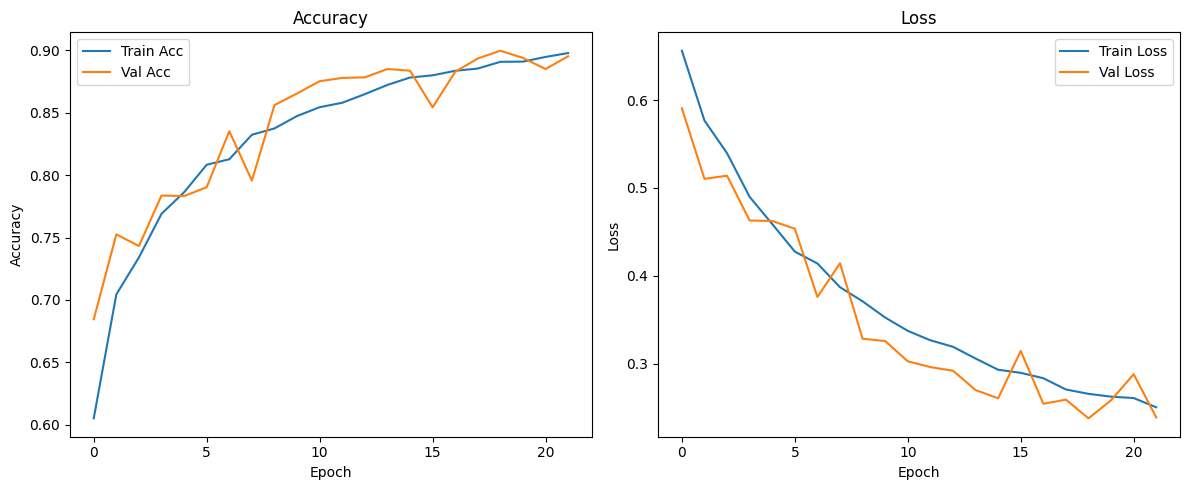

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

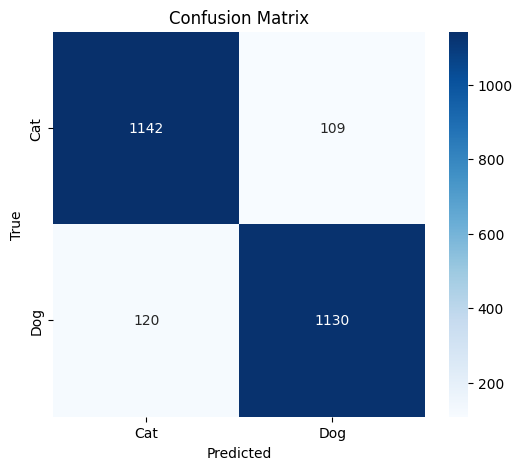

              precision    recall  f1-score   support

         Cat       0.90      0.91      0.91      1251
         Dog       0.91      0.90      0.91      1250

    accuracy                           0.91      2501
   macro avg       0.91      0.91      0.91      2501
weighted avg       0.91      0.91      0.91      2501



In [25]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=0)
y_pred = (y_pred_probs > 0.5).astype('int').flatten()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

In [26]:
def predict_image(path):
    img = image.load_img(path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    label = 'Dog' if pred > 0.5 else 'Cat'
    confidence = float(pred[0][0]) if pred > 0.5 else 1 - float(pred[0][0])
    print(f'Prediction: {label} ({confidence:.2f})')

    plt.imshow(img)
    plt.title(f'{label} ({confidence:.2f})')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: Dog (0.99)


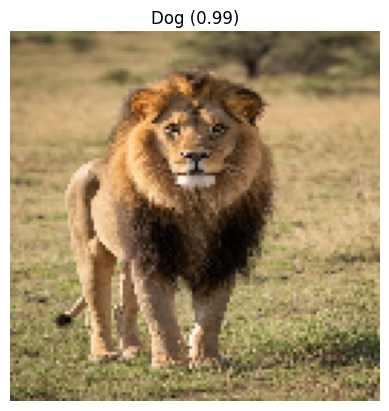

In [36]:
predict_image('/content/drive/MyDrive/Без имени6.jpg')